In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

In [2]:
%matplotlib inline

In [3]:
shots = pd.read_csv("ncaa_by_shot.csv")
shots.head()

,Unnamed: 0,game_id,player_id,player_name,team_id,team_name,class_year,position,goals,sh_att,team_id_opposition,team_name_opposition
0,0,4378055,1908773.0,"Ekdahl, George",19651,High Point,Fr,NaN,1,1,290,Howard
1,1,4379236,1790668.0,"Weyant, Colin",391,UMBC,So,M,1,1,290,Howard
2,2,4382728,1800888.0,"Matteo, Ryan",813,Yale,So,M,1,1,290,Howard
3,3,4382728,1800927.0,"Leisman, John",813,Yale,So,NaN,1,1,290,Howard
4,4,4391432,1906423.0,"Donnelly, JJ",115,Campbell,Fr,NaN,1,1,290,Howard


In [15]:
shooters = shots.groupby('player_name').goals.agg(['sum', 'mean', 'size']).reset_index()
shooters.columns = ['player_name', 'goals', 'proportion', 'attempts']
shooters.head()

,player_name,goals,proportion,attempts
0,"Abdelaoui, Adam",1,0.058824,17
1,"Abderahman, Khalil",1,0.090909,11
2,"Abdi, Faris",1,0.083333,12
3,"Abelein, Casey",0,0.000000,5
4,"Abella, Juan Camilo",0,0.000000,3


In [16]:
shooters[shooters.attempts > 30].sort_values(['proportion', 'attempts'], ascending=False)[0:10]

,player_name,goals,proportion,attempts
2157,"McLaughlin, Garrett",13,0.325000,40
2748,"Pyysalo, Matias",12,0.315789,38
2593,"Patino, Santiago",15,0.312500,48
3604,"Winkel, Bayley",10,0.312500,32
3605,"Winn, Alan",10,0.312500,32
193,"Bagrou, Will",12,0.285714,42
2296,"Moorman, Tyler",11,0.275000,40
1627,"Jepson, Audi",9,0.272727,33
204,"Bakero, Jon",13,0.270833,48
444,"Brodacki, Niklas",14,0.269231,52


In [18]:
team_def = shots.groupby('team_name_opposition').goals.agg(['sum', 'mean', 'size']).reset_index()
team_def.columns = ['team_name_opposition', 'goals', 'proportion', 'attempts']
team_def.sort_values('goals', ascending=False).head()

,team_name_opposition,goals,proportion,attempts
187,VMI,79,0.169892,465
139,Rutgers,49,0.168966,290
201,Wofford,47,0.203463,231
179,UNC Asheville,43,0.141447,304
153,Santa Clara,42,0.178723,235


### Run simple IRT right now cause it's easy and quick

In [19]:
# define the shape of our scale parameters
n_shooters = shooters.shape[0]
n_def = team_def.shape[0]

In [20]:
# be able to index our shooters
shooters['shooter_id'] = range(n_shooters)
team_def['def_id'] = range(n_def)

In [14]:
shooters.head()

,shooter,goals,proportion,attempts,shooter_id
0,"Abdelaoui, Adam",1,0.058824,17,0
1,"Abderahman, Khalil",1,0.090909,11,1
2,"Abdi, Faris",1,0.083333,12,2
3,"Abelein, Casey",0,0.000000,5,3
4,"Abella, Juan Camilo",0,0.000000,3,4


In [21]:
# tack on those id's to our by shot data
shots = pd.merge(shots, shooters, on='player_name')
shots = pd.merge(shots, team_def, on='team_name_opposition')

In [22]:
shots.head()

,Unnamed: 0,game_id,player_id,player_name,team_id,team_name,class_year,position,goals_x,sh_att,team_id_opposition,team_name_opposition,goals_y,proportion_x,attempts_x,shooter_id,goals,proportion_y,attempts_y,def_id
0,0,4378055,1908773.0,"Ekdahl, George",19651,High Point,Fr,NaN,1,1,290,Howard,1,0.2500,4,989,34,0.139344,244,74
1,20,4378055,1908773.0,"Ekdahl, George",19651,High Point,Fr,NaN,0,1,290,Howard,1,0.2500,4,989,34,0.139344,244,74
2,21,4378055,1908773.0,"Ekdahl, George",19651,High Point,Fr,NaN,0,1,290,Howard,1,0.2500,4,989,34,0.139344,244,74
3,1,4379236,1790668.0,"Weyant, Colin",391,UMBC,So,M,1,1,290,Howard,1,0.0625,16,3558,34,0.139344,244,74
4,2,4382728,1800888.0,"Matteo, Ryan",813,Yale,So,M,1,1,290,Howard,1,0.0625,16,2095,34,0.139344,244,74


In [23]:
# pull the lists of importance out
shooter_id = shots.shooter_id.values
def_id = shots.def_id.values
outcome = shots.goals_x

In [24]:
with pm.Model() as irt_model:
    mu_theta = pm.Normal('mu_theta', 0., 10.)
    delta_theta = pm.Normal('delta_theta', 0., 1., shape=n_shooters)
    sigma_theta = pm.HalfStudentT('sigma_theta', nu=3, sd=2.5)
    theta = pm.Deterministic('theta', mu_theta + delta_theta * sigma_theta)
    
    delta_b = pm.Normal('delta_b', 0., 1., shape=n_def)
    sigma_b = pm.HalfStudentT('sigma_b', nu=3, sd=2.5)
    b = pm.Deterministic('b', 0 + delta_b * sigma_b)

In [25]:
with irt_model:
    eta = theta[shooter_id] - b[def_id]
    p = pm.Deterministic('p', pm.math.sigmoid(eta))
    y = pm.Bernoulli('y_obs', p, observed=outcome)

In [38]:
with irt_model:
        irt_trace = pm.sample(1000, tune=1000, random_seed=1112)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  5%|▍         | 91/2000 [02:22<49:45,  1.56s/it]/home/kcm30/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
/home/kcm30/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:431: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
/home/kcm30/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)



/home/kcm30/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: zero-size array to reduction operation minimum which has no identity

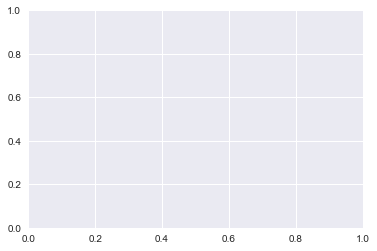

In [39]:
pm.energyplot(irt_trace)

In [35]:
def to_param_df(player_df, trace, varnames, id_column):
    df = player_df
    
    for name in varnames:
        mean = trace[name].mean(axis=0)
        low, high = np.percentile(trace[name], [5, 95], axis=0)
        
        df = df.assign(**{
            '{}_mean'.format(name): mean[df[id_column]],
            '{}_low'.format(name): low[df[id_column]],
            '{}_high'.format(name): high[df[id_column]]
        })
        
    return df

In [36]:
theta_df = to_param_df(shooters, irt_trace, ['theta'], 'shooter_id')
theta_df.head()

/home/kcm30/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
to_plot = theta_df.sort_values('theta_mean', ascending=False)[0:100]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(to_plot.theta_mean.values,
            np.arange(100),
            xerr=np.row_stack([[to_plot.theta_mean.values - to_plot.theta_low.values, to_plot.theta_high.values - to_plot.theta_mean.values]]),
            fmt='o')
ax.set_ylim(-1, 100)
ax.set_yticks(np.arange(100))
ax.set_yticklabels(to_plot.shooter);